In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid, addcyclic
import cosima_cookbook as cc

import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

netcdf_index loaded.


In [2]:
from joblib import Memory

memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

In [3]:
configuration = 'mom01v5'
#configuration = 'mom025'

expts = cc.get_experiments(configuration)
display(expts)

['GFDL50',
 'KDS75',
 'KDS75_PI',
 'KDS75_UP',
 'KDS75_WOA13',
 'KDS75_newbathy_CORE',
 'KDS75_newbathy_JRA',
 'KDS75_newbathy_JRA_runoff',
 'KDS75_salt10days',
 'KDS75_saltfluxes',
 'KDS75_wind']

In [ ]:
configuration = 'access-om2-01'

expts = cc.get_experiments(configuration)
display(expts)

In [4]:
# ncfile = 'ocean.nc'
#expt = 'mom025_jra_ryf9091'
expt = 'KDS75_newbathy_JRA' 

In [5]:
@memory.cache
def load_mld(expt):
    ## Load mld from expt, pick up one year 
    mld = cc.get_nc_variable(expt, 'ocean.nc', 'mld', 
                         time_units = 'days since 1900-01-01')
    mean_mld = mld.sel(time=slice('1902-01','1902-12')).mean('time')
    return mean_mld.load();  # force the calculation

In [6]:
mean_mld = load_mld(expt)

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=19), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [7]:
# 2017-10-24 download from http://www.ifremer.fr/cerweb/deboyer/mld/Surface_Mixed_Layer_Depth.php
obs_filename = '/g/data3/hh5/tmp/cosima/observations/original/mld_DR003_c1m_reg2.0.nc'
obs = xr.open_dataset(obs_filename, decode_times=False)
mean_mld_obs = obs.mld.mean('time')

In [ ]:
# 2017-11-03 download from ftp://ftp2.jamstec.go.jp/pub/argo/MILA_GPV/monthly/mld/2x2/, more data can be downloaded (month and 10days).
#cax6 = ax6.pcolormesh(new_lon_mila, lat_mila, max_mld_mila, shading='flat', cmap=plt.cm.jet, vmin=0.0, vmax=400.0)
mila_obs_filename = '/g/data3/hh5/tmp/cosima/observations/original/ml_MLD_CLIM_ann.nc'
mila_obs = xr.open_dataset(obs_filename, decode_times=False)
mean_mila_mld_obs = mila_obs.mld.mean('time')


MLD should always be positive (right?).  Mask out the negative values in the observations.

In [8]:
mean_mld_obs.data[mean_mld_obs.data < 0] = np.nan

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


Shift the grid of the observations so that it starts from -80W

In [9]:
mean_mld_obs.data, mean_mld_obs.lon.data = shiftgrid(80, mean_mld_obs.data,
                                                 mean_mld_obs.lon.data, 
                                                     cyclic=360, start=True)
mean_mld_obs.lon.data = mean_mld_obs.lon.data - 160

Text(0.5,1,'IFREMER mean MLD obs')

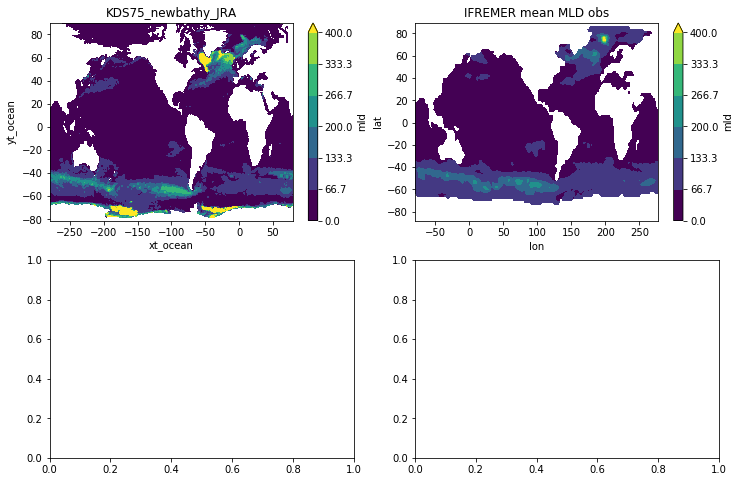

In [12]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

kwargs = {'vmin':0, 'vmax':400}

mean_mld.plot.contourf(ax=ax[0,0], **kwargs)
ax[0,0].set_title(expt)

mean_mld_obs.plot.contourf(ax=ax[0,1], **kwargs)
# ax[0,1].set_title('Observation')
ax[0,1].set_title('IFREMER mean MLD obs')




NameError: name 'lon' is not defined

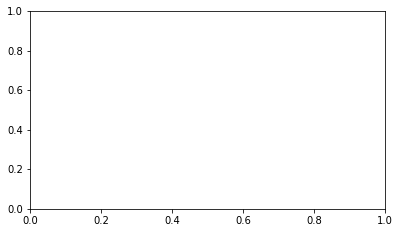

In [11]:
fig = plt.figure(figsize=(14,8))

ax1 = fig.add_subplot(2, 2, 1)
#cax1 = ax1.pcolormesh(x, y, old_m_sst, shading='flat', cmap=plt.cm.jet)
cax1 = ax1.pcolormesh(lon, lat, mld_mom, shading='flat', cmap=plt.cm.jet, vmin=0.0, vmax=400.0)
fig.colorbar(cax1)
#cbar.outline.set_linewidth(1)
plt.title('MOM mean MLD', fontsize=12)

ax2 = fig.add_subplot(2, 2, 2)
#cax1 = ax1.pcolormesh(x, y, old_m_sst, shading='flat', cmap=plt.cm.jet)
cax2 = ax2.pcolormesh(m_mld_obs.lon, m_mld_obs.lat, m_mld_obs, shading='flat', cmap=plt.cm.jet, vmin=0.0, vmax=400.0)
fig.colorbar(cax1)
#cbar.outline.set_linewidth(1)
plt.title('IFREMER mean MLD', fontsize=12)

ax3 = fig.add_subplot(2, 2, 3)
#cax1 = ax1.pcolormesh(x, y, old_m_sst, shading='flat', cmap=plt.cm.jet)
cax3 = ax3.pcolormesh(new_lon_mila, lat_mila, mld_mila, shading='flat', cmap=plt.cm.jet, vmin=0.0, vmax=400.0)
fig.colorbar(cax3)
#cbar.outline.set_linewidth(1)
plt.title('MILA GPV mean MLD', fontsize=12)

#ax4 = fig.add_subplot(2, 2, 4)
##cax1 = ax1.pcolormesh(x, y, old_m_sst, shading='flat', cmap=plt.cm.jet)
#cax4 = ax4.pcolormesh(lon_argo, lat_argo, m_mld_argo, shading='flat', cmap=plt.cm.jet)#, vmin=0.0, vmax=400.0)
#fig.colorbar(cax4)
##cbar.outline.set_linewidth(1)
#plt.title('Argo mean MLD', fontsize=12)

#ax4 = fig.add_subplot(3, 3, 4)
##cax1 = ax1.pcolormesh(x, y, old_m_sst, shading='flat', cmap=plt.cm.jet)
#cax4 = ax4.pcolormesh(lon, lat, max_mld_mom, shading='flat', cmap=plt.cm.jet, vmin=0.0, vmax=400.0)
#fig.colorbar(cax4)
##cbar.outline.set_linewidth(1)
#plt.title('MOM maximum MLD', fontsize=12)
#
#ax5 = fig.add_subplot(3, 3, 5)
##cax1 = ax1.pcolormesh(x, y, old_m_sst, shading='flat', cmap=plt.cm.jet)
#cax5 = ax5.pcolormesh(lon_obs, lat_obs, max_mld_obs, shading='flat', cmap=plt.cm.jet, vmin=0.0, vmax=400.0)
#fig.colorbar(cax5)
##cbar.outline.set_linewidth(1)
#plt.title('IFREMER maximum MLD', fontsize=12)
#
#ax6 = fig.add_subplot(3, 3, 6)
##cax1 = ax1.pcolormesh(x, y, old_m_sst, shading='flat', cmap=plt.cm.jet)
#cax6 = ax6.pcolormesh(new_lon_mila, lat_mila, max_mld_mila, shading='flat', cmap=plt.cm.jet, vmin=0.0, vmax=400.0)
#fig.colorbar(cax6)
##cbar.outline.set_linewidth(1)
#plt.title('MILA GPV maximum MLD', fontsize=12)
#
#ax7 = fig.add_subplot(3, 3, 7)
##cax1 = ax1.pcolormesh(x, y, old_m_sst, shading='flat', cmap=plt.cm.jet)
#cax7 = ax7.pcolormesh(lon, lat, min_mld_mom, shading='flat', cmap=plt.cm.jet, vmin=0.0, vmax=400.0)
#fig.colorbar(cax7)
##cbar.outline.set_linewidth(1)
#plt.title('MOM minimum MLD', fontsize=12)
#
#ax8 = fig.add_subplot(3, 3, 8)
##cax1 = ax1.pcolormesh(x, y, old_m_sst, shading='flat', cmap=plt.cm.jet)
#cax8 = ax8.pcolormesh(lon_obs, lat_obs, min_mld_obs, shading='flat', cmap=plt.cm.jet, vmin=0.0, vmax=400.0)
#fig.colorbar(cax8)
##cbar.outline.set_linewidth(1)
#plt.title('IFREMER minimum MLD', fontsize=12)
#
#ax9 = fig.add_subplot(3, 3, 9)
##cax1 = ax1.pcolormesh(x, y, old_m_sst, shading='flat', cmap=plt.cm.jet)
#cax9 = ax9.pcolormesh(new_lon_mila, lat_mila, min_mld_mila, shading='flat', cmap=plt.cm.jet, vmin=0.0, vmax=400.0)
#fig.colorbar(cax9)
##cbar.outline.set_linewidth(1)
#plt.title('MILA GPV minimum MLD', fontsize=12)